In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
import fasttext
from sklearn.utils import resample
from tqdm import tqdm

2025-03-20 01:15:29.158639: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 01:15:29.365619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742413529.440414    2942 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742413529.464784    2942 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742413529.637768    2942 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
hybrid_df = pd.read_csv("hybrid_sarcasm_dataset_10000.csv")

In [3]:
hybrid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13159 entries, 0 to 13158
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      13159 non-null  object
 1   Source    13110 non-null  object
 2   Language  13110 non-null  object
dtypes: object(3)
memory usage: 308.5+ KB


In [4]:
hybrid_df.head()

,Text,Source,Language
0,first and last comment before this post gets a...,Reddit,en
1,Willie? Won’t he?,Reddit,en
2,Oh come on! That can't be his real name.🤣,Reddit,en
3,choker,Reddit,en
4,Broker,Reddit,en


In [5]:
hybrid_df.isnull().sum()

Text         0
Source      49
Language    49
dtype: int64

In [6]:
sarcasm_detector = pipeline("text-classification", model="bhadresh-savani/bert-base-uncased-emotion")

Device set to use cpu


In [7]:
predictions = []
for text in tqdm(list(hybrid_df['Text']), desc="Predicting sarcasm"):
    prediction = sarcasm_detector(text)
    predictions.append(prediction)

Predicting sarcasm: 100%|██████████| 13159/13159 [21:45<00:00, 10.08it/s]


In [8]:
hybrid_df['label'] = [
    1 if pred[0]['label'].lower() in ["anger", "disgust", "sarcasm"] else 0 
    for pred in predictions
]

In [9]:
print(hybrid_df.tail())

                                                    Text Source Language  \
13154  I have a friend named Akshay. We a group of 5 ...  Quora       en   
13155  Here is the series of some stupid questions as...  Quora       en   
13156  If it’s sarcasm, then it has to be British! Co...  Quora       en   
13157  My friend was involved in this sarcastic warfa...  Quora       en   
13158  Sarcastic Quotes by Famous People "Some cause ...  Quora       en   

       label  
13154      1  
13155      0  
13156      1  
13157      1  
13158      0  


In [10]:
hybrid_df.to_csv("labeled_hybrid_sarcasm_dataset_10000.csv", index=False)
print("Labeled dataset saved successfully!")

Labeled dataset saved successfully!


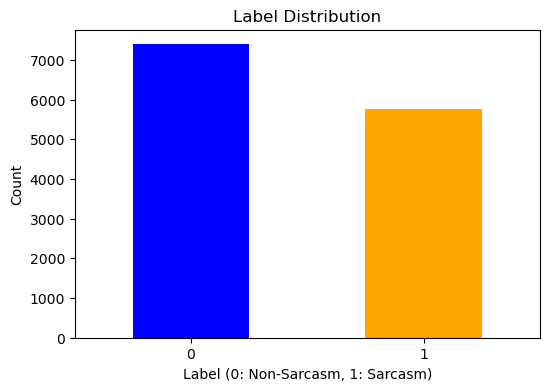

In [11]:
label_counts = hybrid_df['label'].value_counts()
plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title("Label Distribution")
plt.xlabel("Label (0: Non-Sarcasm, 1: Sarcasm)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

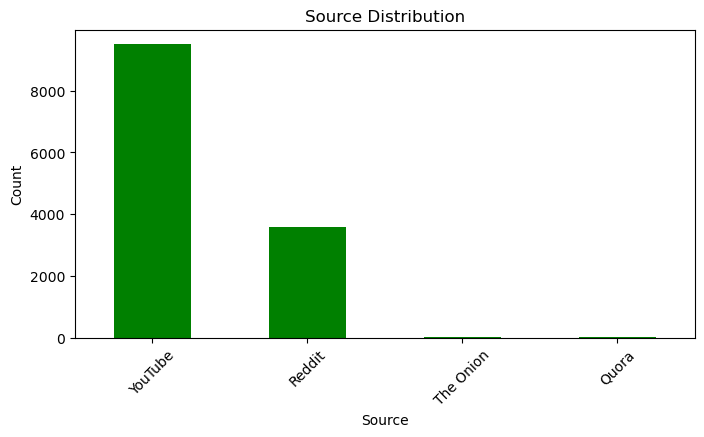

In [12]:
source_counts = hybrid_df['Source'].value_counts()

plt.figure(figsize=(8, 4))
source_counts.plot(kind='bar', color='green')
plt.title("Source Distribution")
plt.xlabel("Source")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

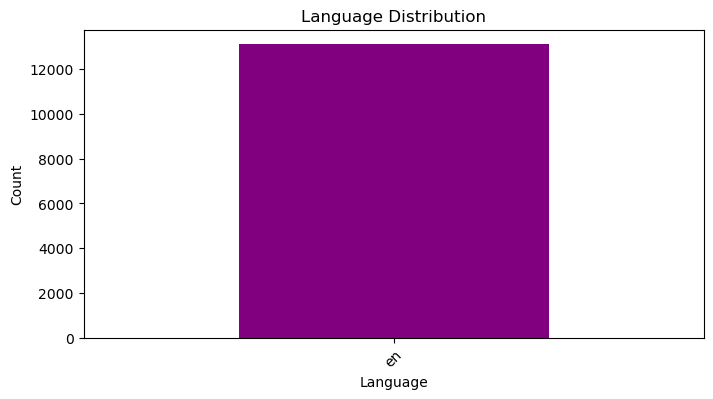

In [13]:
language_counts = hybrid_df['Language'].value_counts()

plt.figure(figsize=(8, 4))
language_counts.plot(kind='bar', color='purple')
plt.title("Language Distribution")
plt.xlabel("Language")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [14]:
model = fasttext.load_model("lid.176.bin")

In [15]:
def detect_language(text):
    predictions = model.predict(text)
    language = predictions[0][0].replace("__label__", "")
    return language

In [16]:
hybrid_df['Language'] = hybrid_df['Text'].apply(detect_language)

In [17]:
print(hybrid_df['Language'].value_counts())

Language
en     10904
es       446
ru       305
de       251
ja       206
       ...  
lt         1
sl         1
tl         1
als        1
hy         1
Name: count, Length: 84, dtype: int64


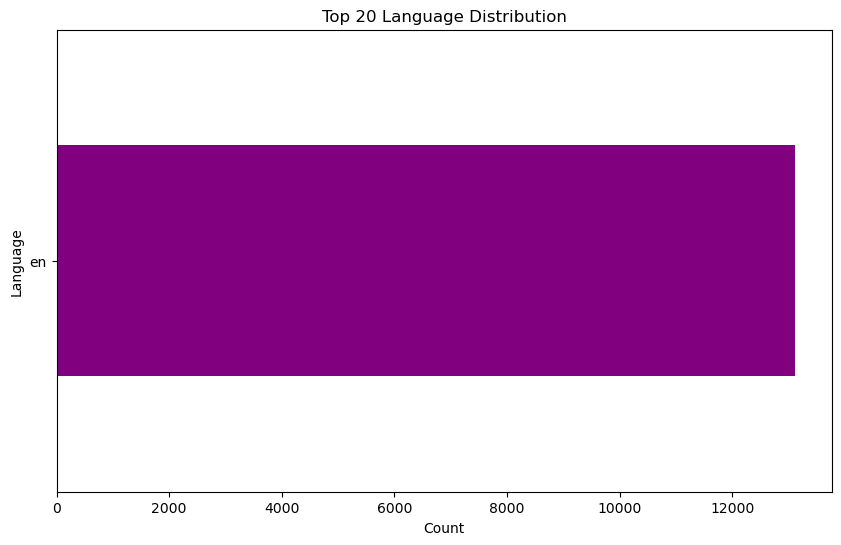

In [27]:
# Display only the top 20 languages to reduce clutter
top_n = 20
top_languages = language_counts.head(top_n)

plt.figure(figsize=(10, 6))
top_languages.plot(kind='barh', color='purple')
plt.title("Top 20 Language Distribution")
plt.xlabel("Count")
plt.ylabel("Language")
plt.gca().invert_yaxis()  
plt.show()

In [20]:
target_size = 1000

In [21]:
balanced_dfs = []

In [22]:
for language in hybrid_df['Language'].unique():
    language_df = hybrid_df[hybrid_df['Language'] == language]
    if len(language_df) > target_size:
        balanced_df = resample(language_df, replace=False, n_samples=target_size, random_state=42)
    else:
        balanced_df = resample(language_df, replace=True, n_samples=target_size, random_state=42)
    balanced_dfs.append(balanced_df)

In [23]:
balanced_hybrid_df = pd.concat(balanced_dfs)

In [24]:
balanced_hybrid_df = balanced_hybrid_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [25]:
print(balanced_hybrid_df['Language'].value_counts())

Language
fr    1000
cs    1000
pa    1000
lb    1000
id    1000
      ... 
ko    1000
an    1000
ru    1000
nl    1000
sw    1000
Name: count, Length: 84, dtype: int64


In [28]:
balanced_hybrid_df.to_csv("balanced_hybrid_sarcasm_dataset_10000.csv", index=False)